Start 1D regenerative cooling (Modified Bartz Eq.(6)+(7), film properties, rib area) ...


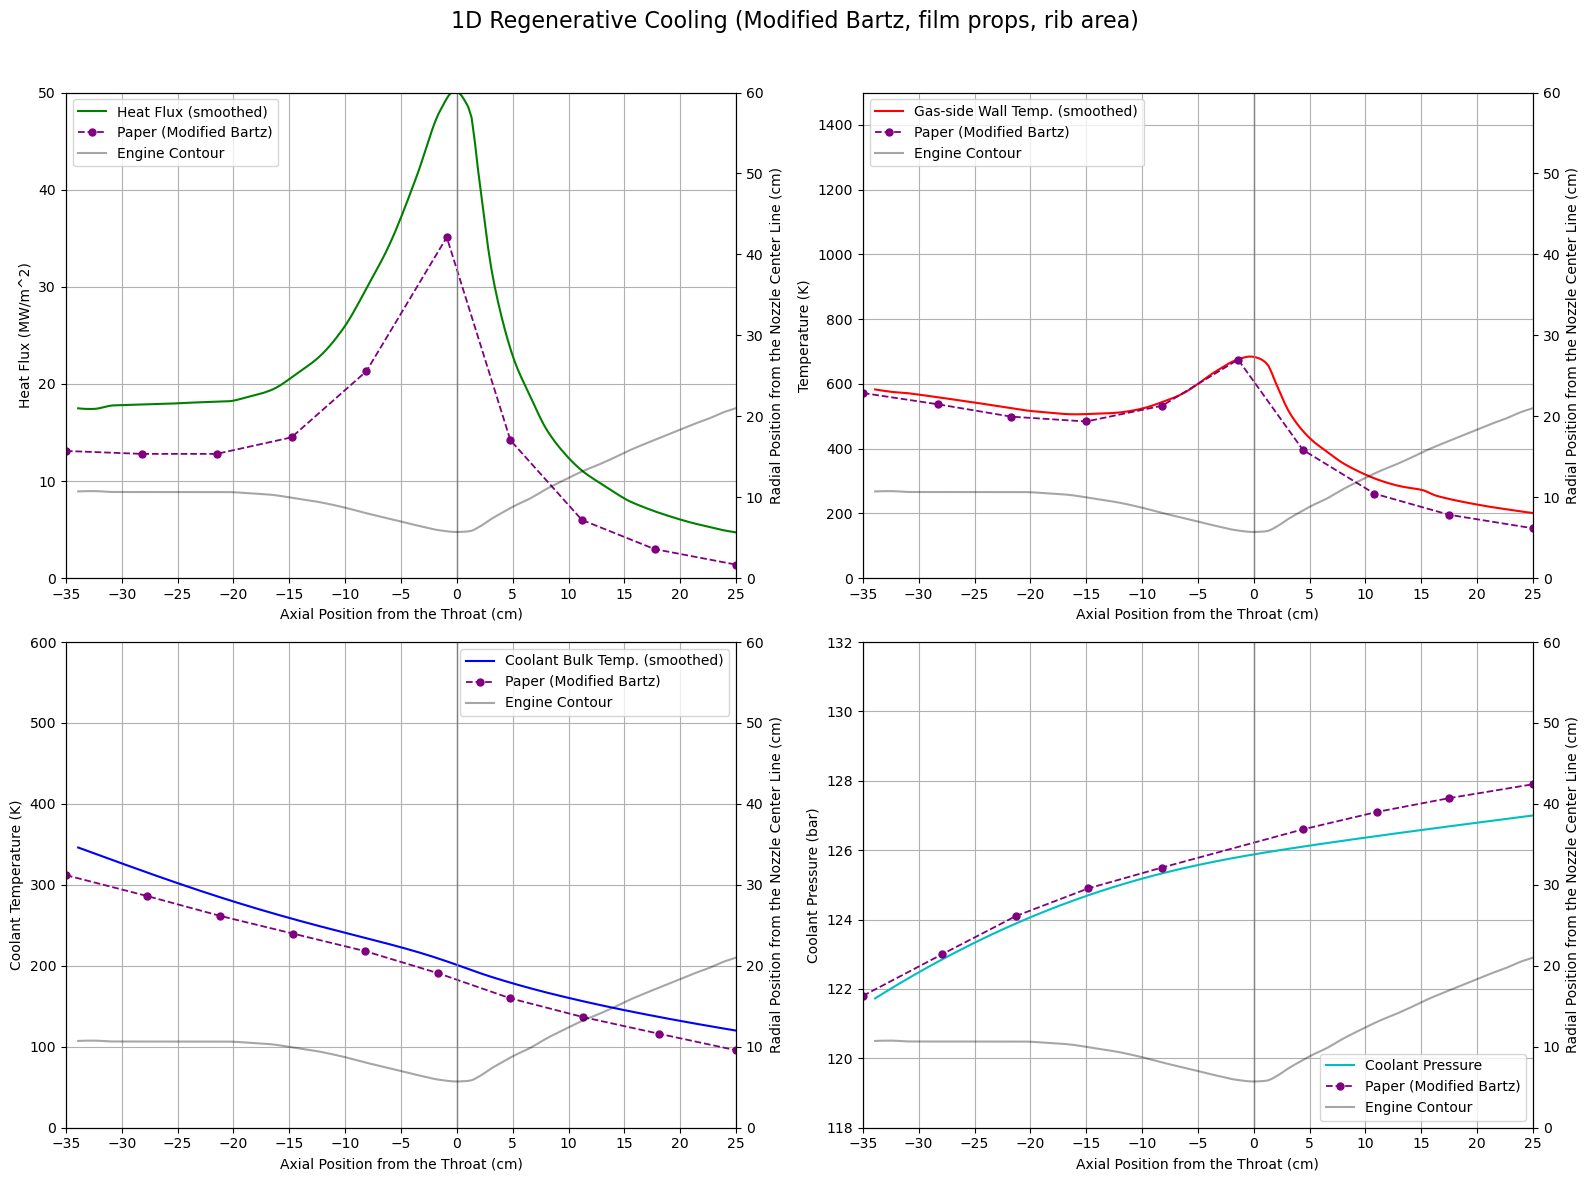

In [10]:
# -*- coding: utf-8 -*-
# 1D 재생냉각 해석 (Cantera + Modified Bartz Eq.(6)+(7) + Rib 핀효율)

import numpy as np
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import cantera as ct
from scipy.interpolate import PchipInterpolator
from scipy.optimize import brentq

# ==============================================================================
# 0) 노즐 형상 (x: 축방향, y=R: 반경) — throat 기준 x=0
# ==============================================================================
class NozzleContour:
    def __init__(self, contour_data_cm):
        data = np.array(contour_data_cm, dtype=float) / 100.0  # cm -> m
        x, y = data[:, 0], data[:, 1]
        s = np.argsort(x)
        self.x_data, self.y_data = x[s], y[s]

        # throat(최소 반경)
        self.throat_idx = np.argmin(self.y_data)
        self.x_throat   = self.x_data[self.throat_idx]
        self.R_t        = self.y_data[self.throat_idx]
        self.D_t        = 2.0 * self.R_t
        self.A_t        = np.pi * self.R_t**2

        # x=0 at throat
        self.x_data_shifted = self.x_data - self.x_throat

        # PCHIP + 1,2차 도함수
        self.spline = PchipInterpolator(self.x_data_shifted, self.y_data, extrapolate=False)
        self.d1     = self.spline.derivative(1)
        self.d2     = self.spline.derivative(2)

        # throat에서 곡률반경 r_c (Modified Bartz 보정항)
        self.r_c_throat = self._curvature_radius(0.0)

    def _curvature_radius(self, x):
        dy  = float(self.d1(x))
        d2y = float(self.d2(x))
        denom = (1.0 + dy*dy)**1.5
        kappa = abs(d2y)/denom if denom > 0 else 0.0
        if kappa < 1e-12:
            return 1e9
        return 1.0 / kappa

    def get_radius(self, x):
        R = self.spline(x)
        R = np.where(np.isnan(R), self.R_t, R)  # 보간 밖 보호
        return np.maximum(R, self.R_t)          # throat 이하로 내려가지 않도록

    def get_profile(self, x):
        R  = self.get_radius(x)
        A  = np.pi * R**2
        D  = 2.0 * R
        AR = A / self.A_t
        return D, AR

# ==============================================================================
# 1) 리브두께 → 핀효율
# ==============================================================================
class RibThicknessProfile:
    def __init__(self, table_cm_mm):
        arr = np.array(table_cm_mm, dtype=float)
        x_cm, t_mm = arr[:, 0], arr[:, 1]
        s = np.argsort(x_cm)
        x_sorted, t_sorted = x_cm[s], t_mm[s]
        ux, idx = np.unique(x_sorted, return_index=True)
        t_unique = t_sorted[idx]
        self.x_m = ux / 100.0
        self.t_m = t_unique / 1000.0
        self._pchip = PchipInterpolator(self.x_m, self.t_m, extrapolate=False)

    def t_rib(self, x_m):
        return np.maximum(self._pchip(x_m), 1e-4)  # 0.1 mm 하한

def fin_efficiency_eta(h_c, k_wall, t_rib, L_fin, tip_correction=True):
    # 양면 대류 평판핀 근사: m = sqrt(2 h / (k t)),  η = tanh(m L_e)/(m L_e)
    t = max(float(t_rib), 1e-6)
    L = max(float(L_fin), 1e-6)
    m  = np.sqrt(2.0 * h_c / (k_wall * t))
    Le = L + 0.5 * t if tip_correction else L
    ml = m * Le
    if ml < 1e-6:
        return 1.0
    return float(np.tanh(ml) / ml)

# ==============================================================================
# 2) Cantera 유틸 (조성/물성/상태/특성속도)
# ==============================================================================
_gas_eq = ct.Solution('gri30.yaml')

def _phi_from_OF(of: float) -> float:
    # CH4/O2 순수 산화제 기준: (O/F)_st = 4.0  → φ = 4.0 / (O/F)
    return 4.0 / of

def gas_props_cantera(T, P, of):
    g = _gas_eq
    phi = _phi_from_OF(of)
    g.set_equivalence_ratio(phi, fuel='CH4', oxidizer='O2')  # 조성(X)
    g.TP = T, P
    g.equilibrate('TP')
    cp, cv = g.cp_mass, g.cv_mass
    gamma  = cp / cv
    mu     = g.viscosity
    k      = g.thermal_conductivity
    Pr     = mu * cp / k
    return gamma, mu, cp, k, Pr

def state_with_cantera(T0, P0, AR, flow_type, of, iters=12):
    gamma = 1.20
    for _ in range(iters):
        M  = mach_from_area_ratio(AR, gamma, flow_type)
        Ts = T0 / (1.0 + 0.5 * (gamma - 1.0) * M**2)
        Ps = P0 * (Ts / T0)**(gamma / (gamma - 1.0))
        gamma_new, mu, cp, k, Pr = gas_props_cantera(Ts, Ps, of)
        if abs(gamma_new - gamma) < 1e-4:
            gamma = gamma_new
            break
        gamma = 0.5 * gamma + 0.5 * gamma_new
    return M, Ts, Ps, gamma, mu, cp, k, Pr

def cstar_cantera(T0, P0, of, iters=15):
    gamma = 1.20
    for _ in range(iters):
        Tt = T0 / (1.0 + 0.5 * (gamma - 1.0))
        Pt = P0 * (Tt / T0)**(gamma / (gamma - 1.0))
        g  = _gas_eq
        phi = _phi_from_OF(of)
        g.set_equivalence_ratio(phi, fuel='CH4:1', oxidizer='O2:1')
        g.TP = Tt, Pt
        g.equilibrate('TP')
        cp, cv = g.cp_mass, g.cv_mass
        gamma_new = cp / cv
        if abs(gamma_new - gamma) < 1e-5:
            gamma = gamma_new
            break
        gamma = 0.5 * gamma + 0.5 * gamma_new
    R = cp - cv
    return (R * T0)**0.5 / (gamma * (2.0/(gamma+1.0))**((gamma+1.0)/(2.0*(gamma-1.0))))

# ==============================================================================
# 3) 유동/열전달
# ==============================================================================
def mach_from_area_ratio(area_ratio, gamma=1.4, flow_type='subsonic'):
    f = lambda M: (1.0/M**2) * ((2.0/(gamma+1.0)) * (1.0 + 0.5*(gamma-1.0)*M*M))**((gamma+1.0)/(gamma-1.0)) - area_ratio**2
    if area_ratio < 1.0:
        raise ValueError("A/A*는 1 이상이어야 합니다.")
    if abs(area_ratio - 1.0) < 1e-14:
        return 1.0
    eps = 1e-12
    if flow_type == 'subsonic':
        return brentq(f, eps, 1.0 - eps)
    a, b = 1.0 + eps, 2.0
    while f(b) <= 0.0:
        b *= 2.0
        if b > 1e6:
            raise RuntimeError("상한 탐색 실패")
    return brentq(f, a, b)

def bartz_eq6_modified(M, T_wg, D_t, A_ratio, P_c, T0,
                       gamma, mu, Cp, Pr, C_star, r_c_throat, w=0.6):
    """
    Modified Bartz — Eq.(6)+(7):
    h_g = [0.026/D_t^0.2 * (mu^0.2*Cp/Pr^0.6) * (P_c/C*)^0.8 * (D_t/r_c)^0.1 * (A*/A)^0.9] * sigma
    """
    # T_aw (adiabatic wall, recovery with Pr^(1/3))
    T_aw = T0 * (1.0 + (Pr**(1.0/3.0)) * 0.5 * (gamma - 1.0) * M*M) / (1.0 + 0.5 * (gamma - 1.0) * M*M)

    # sigma (Eq.7)
    term1 = 0.5 * (T_wg / T0) * (1.0 + 0.5*(gamma - 1.0) * M*M) + 0.5
    sigma = term1**(-(0.8 - w/5.0)) * (1.0 + 0.5*(gamma - 1.0) * M*M)**(-w/5.0)

    rc = max(float(r_c_throat), 1e-6)  # throat curvature radius

    h_g = (0.026 / (D_t**0.2)) * ((mu**0.2 * Cp) / (Pr**0.6)) \
          * (P_c / C_star)**0.8 * (D_t/rc)**0.1 * (1.0 / A_ratio)**0.9 * sigma
    return h_g, T_aw

def _friction_factor_colebrook(Re, D_h, eps=1e-6):
    if Re < 2300.0:
        return 64.0 / Re
    g = lambda f: 1.0/np.sqrt(f) + 2.0*np.log10(eps/D_h/3.7 + 2.51/(Re*np.sqrt(f)))
    return brentq(g, 1e-6, 0.2)

def calculate_pressure_drop(m_dot_c, T_c, P_c, A_c, d_h, dx, fluid):
    rho = CP.PropsSI('D', 'T', T_c, 'P', P_c, fluid)
    mu  = CP.PropsSI('V', 'T', T_c, 'P', P_c, fluid)
    v   = m_dot_c / (A_c * rho)
    Re  = rho * v * d_h / mu
    f   = _friction_factor_colebrook(Re, d_h, eps=1e-6)
    return float(f * (dx/d_h) * 0.5 * rho * v * v)

def calculate_h_c(m_dot_c, A_c, d_h, T_c, T_wc, P_c, fluid='Methane', eta_fin=1.0):
    # Dittus–Boelter 유지 (Gnielinski 미적용)
    if not (91 < T_c < 600 and 1e5 < P_c < 200e5):
        return 3.0e4 * eta_fin
    rho = CP.PropsSI('D', 'T', T_c, 'P', P_c, fluid)
    cp  = CP.PropsSI('C', 'T', T_c, 'P', P_c, fluid)
    mu  = CP.PropsSI('V', 'T', T_c, 'P', P_c, fluid)
    k   = CP.PropsSI('L', 'T', T_c, 'P', P_c, fluid)
    Pr  = cp * mu / k
    v   = m_dot_c / (A_c * rho)
    Re  = rho * v * d_h / mu
    if Re < 4000:
        return 1.0e3 * eta_fin
    Nu  = 0.023 * (Re**0.8) * (Pr**0.4)
    h   = Nu * k / d_h
    return h * eta_fin

# ==============================================================================
# 4) 입력 (논문 Table 1,2 기반)
# ==============================================================================
nozzle_contour_data = np.array([
    [-35,10.72], [-33.6,10.76], [-31.8,10.65], [-30.2,10.65], [-28.3,10.65],
    [-26.5,10.65], [-24.5,10.64], [-21.6,10.64], [-20.0,10.53], [-17.8,10.32],
    [-15.3, 9.81], [-13.4, 9.40], [-11.3, 8.78],  [-9.0, 7.96],  [-7.4, 7.45],
     [-4.7, 6.53],  [-2.6, 5.91],  [-1.1, 5.71],   [0.05, 5.81],  [1.0, 6.42],
     [2.0, 7.33],   [2.9, 8.05],   [4.1, 8.96],   [5.5, 9.88],   [6.9, 11.0],
     [8.5,12.12],  [10.2,13.24], [11.8,14.15], [13.1,14.96], [14.5,15.88],
    [16.1,16.80], [18.1,17.91], [20.1,19.03], [21.5,19.74], [22.9,20.56],
    [23.8,20.96], [25,21.57]
])

rib_contour_data = np.array([
    [-35,3.4], [-31.0,3.4], [-27.1,3.4], [-23.0,3.4], [-19.2,3.3], [15.2,3.1],
    [-11.2,2.6], [-7.2,2.1], [-3.2,1.5], [0.5,1.5], [4.5,2.8],
    [8.5,4.0], [12.5,5.1], [16.5,5.1], [20.4,7.0], [25,7.8]
])

heat_flux_data = np.array([
    [-35,13.1], [-28.2,12.8], [-21.5,12.8], [-14.8,14.5], [-8.1,21.3], [-0.9,35.1],
     [4.8,14.2], [11.2,6], [17.7,3.0], [25,1.4]
])

T_wg_data = np.array([
    [-35, 572.0], [-28.3, 537.3], [-21.7, 498.9], [-15.0, 484.0], [-8.2, 532.7], [-1.4, 675.2],
    [4.4, 396.4], [10.8, 261.2], [17.5, 195.9], [25, 154.2]
])

T_c_data = np.array([
    [-35, 312.0], [-27.7, 286.1], [-21.2, 261.7], [-14.7, 239.9], [-8.2, 218.1], [-1.7, 191],
    [4.8, 159.8], [11.3, 136.7], [18.1, 116.1], [25, 95.7]
])
P_c_data = np.array([
    [-35, 121.8], [-27.9, 123.0], [-21.3, 124.1], [-14.8, 124.9], [-8.2, 125.5], [4.4, 126.6],
    [11.0, 127.1], [17.5, 127.5], [25, 127.9]
])
# 챔버 조건 (Table 1)
T_0 = 3603.2       # K
P_0 = 58.6e5       # Pa
O_F = 3.5          # 질량비

# 특성속도 (Cantera 계산)
C_star = cstar_cantera(T_0, P_0, O_F)

# 냉각 채널/재료 (Table 2)
wall_thickness = 0.7e-3
channel_height = 8.63e-3
channel_width  = 1.08e-3
num_channels   = 150
k_wall         = 500.0      # 구리 라이너 가정 (인코넬은 ~20–25 사용)
COOLANT_NAME   = 'Methane'
m_dot_coolant  = 8#6.858      # kg/s (설계 입력)
T_c_inlet      = 120.0      # K
P_c_inlet      = 127e5      # Pa
cooling_jacket_end_ar = 15.0

# 파생
nozzle      = NozzleContour(nozzle_contour_data)
rib_profile = RibThicknessProfile(rib_contour_data)

D_t        = nozzle.D_t
A_c_total  = channel_width * channel_height * num_channels
d_h        = 2.0 * (channel_width * channel_height) / (channel_width + channel_height)
r_c_throat = nozzle.r_c_throat

# 해석 세팅
n_segments  = 200
tol         = 1e-5
max_iter    = 5000
alpha_relax = 0.5

# 해석 구간: 수축부 끝 ~ 팽창부 AR=15
x_start = nozzle.x_data_shifted[0]
x_end   = 0.25
for xv in np.linspace(0, 0.5, 500):
    _, ar = nozzle.get_profile(xv)
    if ar >= cooling_jacket_end_ar:
        x_end = xv
        break
x_pos = np.linspace(x_start, x_end, n_segments)
dx    = x_pos[1] - x_pos[0]

# 결과 배열
D_profile   = np.zeros(n_segments)
AR_profile  = np.zeros(n_segments)
T_c_profile = np.zeros(n_segments)
P_c_profile = np.zeros(n_segments)
T_wg_profile= np.zeros(n_segments)
T_wc_profile= np.zeros(n_segments)
q_profile   = np.zeros(n_segments)
h_g_profile = np.zeros(n_segments)

# 경계조건(출구에서 입구로 적분)
T_c_profile[-1] = T_c_inlet
P_c_profile[-1] = P_c_inlet
T_wg_guess_next = 600.0

# ==============================================================================
# 5) 메인 루프
# ==============================================================================
print("Start 1D regenerative cooling (Modified Bartz Eq.(6)+(7), film properties, rib area) ...")

for i in range(n_segments - 1, -1, -1):
    x = x_pos[i]
    D_local, AR_local = nozzle.get_profile(x)
    D_profile[i], AR_profile[i] = D_local, AR_local

    T_c_local, P_c_local = T_c_profile[i], P_c_profile[i]

    flow_type = 'subsonic' if x < 0.0 else 'supersonic'
    M, T_s, P_s, gamma_s, mu_s, cp_s, k_s, Pr_s = state_with_cantera(T_0, P_0, AR_local, flow_type, O_F)

    # 반복 초기화(조기 break 보호)
    T_wg_iter = float(T_wg_guess_next)
    h_g = 1.0
    T_aw = T_s
    q = 0.0
    Twc = float(T_c_local)
    Twg_new = float(T_wg_iter)

    # 가스측 h_g: 1) Ts에서 1차 → T_aw0 → 2) T_film에서 최종 h_g
    for _ in range(max_iter):
        # 1차: 정적온도 물성으로 T_aw 예측
        h_g_tmp, T_aw0 = bartz_eq6_modified(M, T_wg_iter, D_t, AR_local, P_0, T_0,
                                            gamma_s, mu_s, cp_s, Pr_s, C_star, r_c_throat, w=0.6)
        # 필름온도 물성 재평가
        T_film = max(0.5*(T_aw0 + T_wg_iter), 300.0)  # 수치안정 하한
        gamma_f, mu_f, cp_f, k_f, Pr_f = gas_props_cantera(T_film, P_s, O_F)
        h_g, T_aw = bartz_eq6_modified(M, T_wg_iter, D_t, AR_local, P_0, T_0,
                                       gamma_f, mu_f, cp_f, Pr_f, C_star, r_c_throat, w=0.6)

        # 냉각측: Dittus–Boelter 원시 h_c
        h_c_raw = calculate_h_c(m_dot_coolant, A_c_total, d_h, T_c_local, T_wg_iter,
                                P_c_local, COOLANT_NAME, eta_fin=1.0)   # ← η 여기선 1.0

        # 핀효율: 핀 길이 = 채널 높이 (channel_height)
        t_rib_loc = float(rib_profile.t_rib(x))
        eta_fin   = fin_efficiency_eta(h_c_raw, k_wall, t_rib_loc, channel_height, tip_correction=True)

        # 리브 면적 증대 비(φ) = 1 + η_f * (2H/p),  p ≈ 둘레/리브개수
        R_gas     = nozzle.get_radius(x)                 # 가스측 반경
        circ_cool = 2.0 * np.pi * (R_gas + wall_thickness)
        pitch     = max(circ_cool / num_channels, 1e-6)
        area_ratio = 1.0 + eta_fin * (2.0 * channel_height) / pitch

        # 등가 냉각측 h (외부 기준) : h_c,eff = h_c,raw * φ
        h_c_eff = max(h_c_raw * area_ratio, 1.0)

        # 열저항망
        Rg = 1.0 / max(h_g, 1e-12)
        Rw = wall_thickness / k_wall
        Rc = 1.0 / h_c_eff

        q       = max((T_aw - T_c_local) / (Rg + Rw + Rc), 0.0)  # W/m^2
        Twc     = T_c_local + q * Rc
        Twg_new = T_aw - q * Rg

        if not np.isfinite(Twg_new):
            break
        if abs(Twg_new - T_wg_iter) < tol:
            break

        T_wg_iter = (1.0 - alpha_relax) * T_wg_iter + alpha_relax * Twg_new

    T_wg_profile[i] = Twg_new
    T_wc_profile[i] = Twc
    q_profile[i]    = q
    h_g_profile[i]  = h_g
    T_wg_guess_next = Twg_new

    # 냉각수 다음 구간 상태
    if i > 0:
        A_ht  = np.pi * D_local * dx
        Q_seg = q * A_ht
        Cp_c  = CP.PropsSI('C', 'T', T_c_local, 'P', P_c_local, COOLANT_NAME)
        T_c_profile[i-1] = T_c_local + Q_seg / (m_dot_coolant * Cp_c)
        dP = calculate_pressure_drop(m_dot_coolant, T_c_local, P_c_local, A_c_total, d_h, dx, COOLANT_NAME)
        P_c_profile[i-1] = P_c_local - dP

# ==============================================================================
# 6) Plot  — 논문(Fig.6–8)과 축/범위 일치 + 논문 보라색(Modified Bartz) 점 오버레이
# ==============================================================================
x_cm = x_pos * 100.0                      # m → cm
R_cm = (D_profile * 0.5) * 100.0          # 노즐 반경 [cm]

q_s   = q_profile
Tgw_s = T_wg_profile
Tc_s  = T_c_profile

# 논문 보라색 데이터 (그대로 사용: x는 cm, y단위는 그림 축과 일치)
x_hf_ref,  hf_ref  = heat_flux_data[:,0], heat_flux_data[:,1]   # MW/m^2
x_Twg_ref, Twg_ref = T_wg_data[:,0],     T_wg_data[:,1]         # K
x_Tc_ref,  Tc_ref  = T_c_data[:,0],      T_c_data[:,1]          # K
x_Pc_ref,  Pc_ref  = P_c_data[:,0],      P_c_data[:,1]          # bar

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('1D Regenerative Cooling (Modified Bartz, film props, rib area)', fontsize=16)

# --- Heat flux (Fig. 6a) ---
ax1_t = ax1.twinx()
ax1.plot(x_cm, q_s/1e6, '-', color='g', label='Heat Flux (smoothed)')
# 논문 보라색 점/선
ax1.plot(x_hf_ref, hf_ref, 'o--', color='purple', lw=1.3, ms=5,
         label='Paper (Modified Bartz)')
# 엔진 외곽선
ax1_t.plot(x_cm, R_cm, 'k', alpha=0.35, label='Engine Contour')
ax1.set_xlabel('Axial Position from the Throat (cm)')
ax1.set_ylabel('Heat Flux (MW/m^2)')
ax1_t.set_ylabel('Radial Position from the Nozzle Center Line (cm)')
ax1.set_xlim(-35, 25); ax1.set_ylim(0, 50); ax1_t.set_ylim(0, 60)
ax1.set_xticks(np.arange(-35, 26, 5)); ax1.grid(True)
h1,l1 = ax1.get_legend_handles_labels(); h2,l2 = ax1_t.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left')

# --- Gas-side wall temperature (Fig. 6b) ---
ax2_t = ax2.twinx()
ax2.plot(x_cm, Tgw_s, '-', color='r', label='Gas-side Wall Temp. (smoothed)')
ax2.plot(x_Twg_ref, Twg_ref, 'o--', color='purple', lw=1.3, ms=5,
         label='Paper (Modified Bartz)')
ax2_t.plot(x_cm, R_cm, 'k', alpha=0.35, label='Engine Contour')
ax2.set_xlabel('Axial Position from the Throat (cm)')
ax2.set_ylabel('Temperature (K)')
ax2_t.set_ylabel('Radial Position from the Nozzle Center Line (cm)')
ax2.set_xlim(-35, 25); ax2.set_ylim(0, 1500); ax2_t.set_ylim(0, 60)
ax2.set_xticks(np.arange(-35, 26, 5)); ax2.grid(True)
h1,l1 = ax2.get_legend_handles_labels(); h2,l2 = ax2_t.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc='upper left')

# --- Coolant temperature (Fig. 7) ---
ax3_t = ax3.twinx()
ax3.plot(x_cm, Tc_s, '-', color='b', label='Coolant Bulk Temp. (smoothed)')
ax3.plot(x_Tc_ref, Tc_ref, 'o--', color='purple', lw=1.3, ms=5,
         label='Paper (Modified Bartz)')
ax3_t.plot(x_cm, R_cm, 'k', alpha=0.35, label='Engine Contour')
ax3.set_xlabel('Axial Position from the Throat (cm)')
ax3.set_ylabel('Coolant Temperature (K)')
ax3_t.set_ylabel('Radial Position from the Nozzle Center Line (cm)')
ax3.set_xlim(-35, 25); ax3.set_ylim(0, 600); ax3_t.set_ylim(0, 60)
ax3.set_xticks(np.arange(-35, 26, 5)); ax3.grid(True)
h1,l1 = ax3.get_legend_handles_labels(); h2,l2 = ax3_t.get_legend_handles_labels()
ax3.legend(h1+h2, l1+l2, loc='upper right')

# --- Coolant pressure (Fig. 8) ---
ax4_t = ax4.twinx()
ax4.plot(x_cm, P_c_profile/1e5, '-', color='c', label='Coolant Pressure')
ax4.plot(x_Pc_ref, Pc_ref, 'o--', color='purple', lw=1.3, ms=5,
         label='Paper (Modified Bartz)')
ax4_t.plot(x_cm, R_cm, 'k', alpha=0.35, label='Engine Contour')
ax4.set_xlabel('Axial Position from the Throat (cm)')
ax4.set_ylabel('Coolant Pressure (bar)')
ax4_t.set_ylabel('Radial Position from the Nozzle Center Line (cm)')
ax4.set_xlim(-35, 25); ax4.set_ylim(118, 132); ax4_t.set_ylim(0, 60)
ax4.set_xticks(np.arange(-35, 26, 5)); ax4.grid(True)
h1,l1 = ax4.get_legend_handles_labels(); h2,l2 = ax4_t.get_legend_handles_labels()
ax4.legend(h1+h2, l1+l2, loc='lower right')

for ax in (ax1, ax2, ax3, ax4):
    ax.axvline(0, color='grey', lw=1)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




Start 1D regenerative cooling (Modified Bartz Eq.(6)+(7), frozen props, rib area) ...


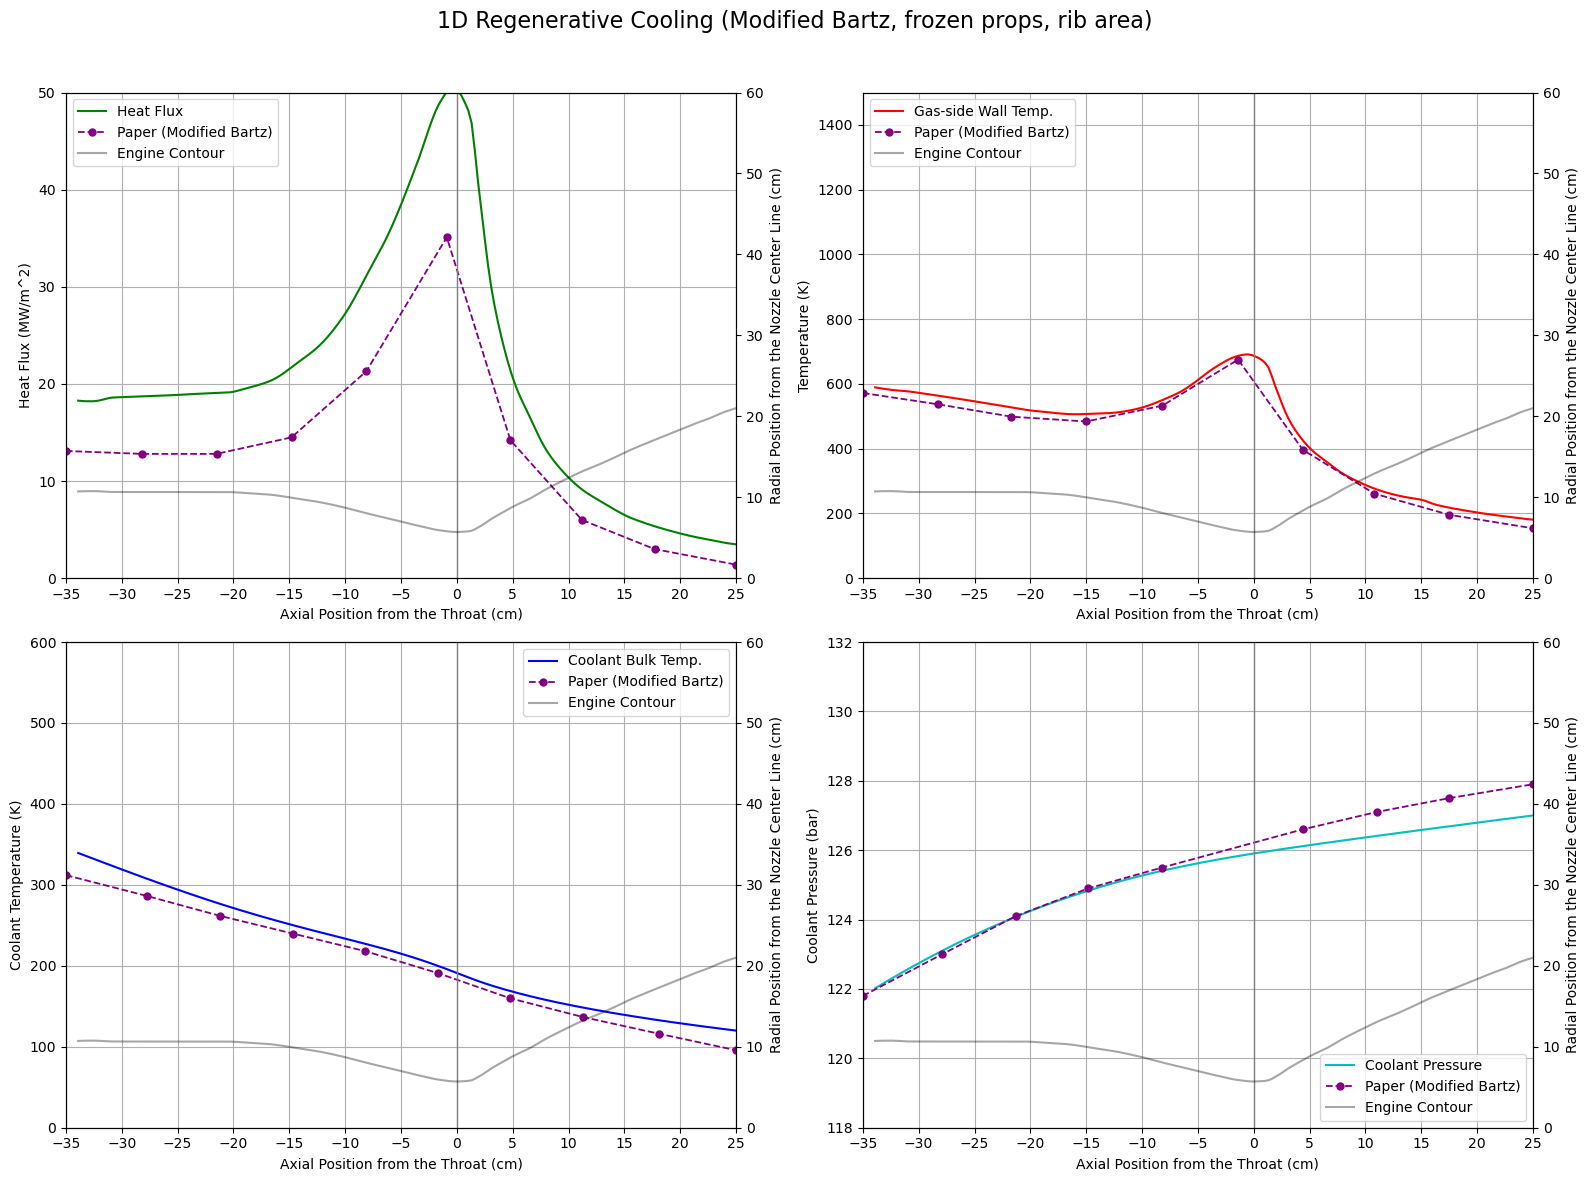

In [ ]:
# -*- coding: utf-8 -*-
# 1D 재생냉각 해석 (Cantera + Modified Bartz Eq.(6)+(7) + Rib 핀효율)
# Dittus–Boelter 유지 (Gnielinski 미적용) / Frozen composition + c* from chamber
import numpy as np
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import cantera as ct
from scipy.interpolate import PchipInterpolator
from scipy.optimize import brentq

# ==============================================================================
# 0) 노즐 형상 (x: 축방향, y=R: 반경) — throat 기준 x=0
# ==============================================================================
class NozzleContour:
    def __init__(self, contour_data_cm):
        data = np.array(contour_data_cm, dtype=float) / 100.0  # cm -> m
        x, y = data[:, 0], data[:, 1]
        s = np.argsort(x)
        self.x_data, self.y_data = x[s], y[s]

        # throat(최소 반경)
        self.throat_idx = np.argmin(self.y_data)
        self.x_throat   = self.x_data[self.throat_idx]
        self.R_t        = self.y_data[self.throat_idx]
        self.D_t        = 2.0 * self.R_t
        self.A_t        = np.pi * self.R_t**2

        # x=0 at throat
        self.x_data_shifted = self.x_data - self.x_throat

        # PCHIP + 1,2차 도함수
        self.spline = PchipInterpolator(self.x_data_shifted, self.y_data, extrapolate=False)
        self.d1     = self.spline.derivative(1)
        self.d2     = self.spline.derivative(2)

        # throat에서 곡률반경 r_c (Modified Bartz 보정항)
        self.r_c_throat = self._curvature_radius(0.0)

    def _curvature_radius(self, x):
        dy  = float(self.d1(x))
        d2y = float(self.d2(x))
        denom = (1.0 + dy*dy)**1.5
        kappa = abs(d2y)/denom if denom > 0 else 0.0
        if kappa < 1e-12:
            return 1e9
        return 1.0 / kappa

    def get_radius(self, x):
        R = self.spline(x)
        R = np.where(np.isnan(R), self.R_t, R)  # 보간 밖 보호
        return np.maximum(R, self.R_t)          # throat 이하로 내려가지 않도록

    def get_profile(self, x):
        R  = self.get_radius(x)
        A  = np.pi * R**2
        D  = 2.0 * R
        AR = A / self.A_t
        return D, AR

# ==============================================================================
# 1) 리브두께 → 핀효율
# ==============================================================================
class RibThicknessProfile:
    def __init__(self, table_cm_mm):
        arr = np.array(table_cm_mm, dtype=float)
        x_cm, t_mm = arr[:, 0], arr[:, 1]
        s = np.argsort(x_cm)
        x_sorted, t_sorted = x_cm[s], t_mm[s]
        ux, idx = np.unique(x_sorted, return_index=True)
        t_unique = t_sorted[idx]
        self.x_m = ux / 100.0
        self.t_m = t_unique / 1000.0
        self._pchip = PchipInterpolator(self.x_m, self.t_m, extrapolate=False)

    def t_rib(self, x_m):
        return np.maximum(self._pchip(x_m), 1e-4)  # 0.1 mm 하한

def fin_efficiency_eta(h_c, k_wall, t_rib, L_fin, tip_correction=True):
    # 양면 대류 평판핀 근사: m = sqrt(2 h / (k t)),  η = tanh(m L_e)/(m L_e)
    t = max(float(t_rib), 1e-6)
    L = max(float(L_fin), 1e-6)
    m  = np.sqrt(2.0 * h_c / (k_wall * t))
    Le = L + 0.5 * t if tip_correction else L
    ml = m * Le
    if ml < 1e-6:
        return 1.0
    return float(np.tanh(ml) / ml)

# ==============================================================================
# 2) Cantera 유틸 (동결 조성, 챔버에서 고정) + c* from chamber
# ==============================================================================
_GAS = ct.Solution('gri30.yaml')
Y_FROZEN = None
GAMMA_CHAMBER = None
R_CHAMBER = None

def set_frozen_composition(of, T0, P0):
    """챔버에서 HP 평형으로 조성 고정 → 전 구간 frozen 물성 사용"""
    global _GAS, Y_FROZEN, GAMMA_CHAMBER, R_CHAMBER
    phi = 4.0 / of  # CH4/O2
    _GAS.set_equivalence_ratio(phi, fuel='CH4', oxidizer='O2')
    _GAS.TP = T0, P0
    _GAS.equilibrate('HP')  # 챔버에서 평형 → 조성 고정
    Y_FROZEN = _GAS.Y.copy()
    cp0 = _GAS.cp_mass; cv0 = _GAS.cv_mass
    GAMMA_CHAMBER = cp0 / cv0
    R_CHAMBER = cp0 - cv0
    return Y_FROZEN, GAMMA_CHAMBER, R_CHAMBER

def gas_props_frozen(T, P):
    """동결 조성(Y_FROZEN)으로 γ, μ, k, cp, Pr 계산"""
    _GAS.TPY = T, P, Y_FROZEN
    cp = _GAS.cp_mass; cv = _GAS.cv_mass
    gamma = cp / cv
    mu = _GAS.viscosity
    k  = _GAS.thermal_conductivity
    Pr = mu * cp / k
    return gamma, mu, cp, k, Pr

def state_with_frozen(T0, P0, AR, flow_type, iters=12):
    """면적비→M 반복(γ는 동결 조성으로 T,P에 의존)"""
    gamma = 1.20
    for _ in range(iters):
        M  = mach_from_area_ratio(AR, gamma, flow_type)
        Ts = T0 / (1.0 + 0.5 * (gamma - 1.0) * M*M)
        Ps = P0 * (Ts / T0)**(gamma / (gamma - 1.0))
        gamma_new, mu, cp, k, Pr = gas_props_frozen(Ts, Ps)
        if abs(gamma_new - gamma) < 1e-4:
            gamma = gamma_new
            break
        gamma = 0.5 * (gamma + gamma_new)
    return M, Ts, Ps, gamma, mu, cp, k, Pr

def cstar_from_chamber(T0, P0):
    """챔버 혼합기(동결)의 R, γ로 c* 계산 (정확식)"""
    gamma = GAMMA_CHAMBER
    R = R_CHAMBER
    return np.sqrt(R*T0/gamma) * ((gamma+1.0)/2.0)**((gamma+1.0)/(2.0*(gamma-1.0)))

# ==============================================================================
# 3) 유동/열전달
# ==============================================================================
def mach_from_area_ratio(area_ratio, gamma=1.4, flow_type='subsonic'):
    f = lambda M: (1.0/M**2) * ((2.0/(gamma+1.0)) * (1.0 + 0.5*(gamma-1.0)*M*M))**((gamma+1.0)/(gamma-1.0)) - area_ratio**2
    if area_ratio < 1.0:
        raise ValueError("A/A*는 1 이상이어야 합니다.")
    if abs(area_ratio - 1.0) < 1e-14:
        return 1.0
    eps = 1e-12
    if flow_type == 'subsonic':
        return brentq(f, eps, 1.0 - eps)
    a, b = 1.0 + eps, 2.0
    while f(b) <= 0.0:
        b *= 2.0
        if b > 1e6:
            raise RuntimeError("상한 탐색 실패")
    return brentq(f, a, b)

def bartz_eq6_modified(M, T_wg, D_t, A_ratio, P_c, T0,
                       gamma, mu, Cp, Pr, C_star, r_c_throat, w=0.6):
    """
    Modified Bartz — Eq.(6)+(7):
    h_g = [0.026/D_t^0.2 * (mu^0.2*Cp/Pr^0.6) * (P_c/C*)^0.8 * (D_t/r_c)^0.1 * (A*/A)^0.9] * sigma
    """
    # T_aw (adiabatic wall, recovery with Pr^(1/3))
    T_aw = T0 * (1.0 + (Pr**(1.0/3.0)) * 0.5 * (gamma - 1.0) * M*M) / (1.0 + 0.5 * (gamma - 1.0) * M*M)

    # sigma (Eq.7)
    term1 = 0.5 * (T_wg / T0) * (1.0 + 0.5*(gamma - 1.0) * M*M) + 0.5
    sigma = term1**(-(0.8 - w/5.0)) * (1.0 + 0.5*(gamma - 1.0) * M*M)**(-w/5.0)

    rc = max(float(r_c_throat), 1e-6)  # throat curvature radius

    h_g = (0.026 / (D_t**0.2)) * ((mu**0.2 * Cp) / (Pr**0.6)) \
          * (P_c / C_star)**0.8 * (D_t/rc)**0.1 * (1.0 / A_ratio)**0.9 * sigma
    return h_g, T_aw

def _friction_factor_colebrook(Re, D_h, eps=1e-6):
    if Re < 2300.0:
        return 64.0 / Re
    g = lambda f: 1.0/np.sqrt(f) + 2.0*np.log10(eps/D_h/3.7 + 2.51/(Re*np.sqrt(f)))
    return brentq(g, 1e-6, 0.2)

def calculate_pressure_drop(m_dot_c, T_c, P_c, A_c, d_h, dx, fluid):
    rho = CP.PropsSI('D', 'T', T_c, 'P', P_c, fluid)
    mu  = CP.PropsSI('V', 'T', T_c, 'P', P_c, fluid)
    v   = m_dot_c / (A_c * rho)
    Re  = rho * v * d_h / mu
    f   = _friction_factor_colebrook(Re, d_h, eps=1e-6)
    return float(f * (dx/d_h) * 0.5 * rho * v * v)

def calculate_h_c(m_dot_c, A_c, d_h, T_c, T_wc, P_c, fluid='Methane', eta_fin=1.0):
    # Dittus–Boelter 유지 (Gnielinski 미적용)
    if not (91 < T_c < 600 and 1e5 < P_c < 200e5):
        return 3.0e4 * eta_fin
    rho = CP.PropsSI('D', 'T', T_c, 'P', P_c, fluid)
    cp  = CP.PropsSI('C', 'T', T_c, 'P', P_c, fluid)
    mu  = CP.PropsSI('V', 'T', T_c, 'P', P_c, fluid)
    k   = CP.PropsSI('L', 'T', T_c, 'P', P_c, fluid)
    Pr  = cp * mu / k
    v   = m_dot_c / (A_c * rho)
    Re  = rho * v * d_h / mu
    if Re < 4000:
        return 1.0e3 * eta_fin
    Nu  = 0.023 * (Re**0.8) * (Pr**0.4)
    h   = Nu * k / d_h
    return h * eta_fin

# ==============================================================================
# 4) 입력 (논문 Table 1,2 기반)
# ==============================================================================
nozzle_contour_data = np.array([
    [-35,10.72], [-33.6,10.76], [-31.8,10.65], [-30.2,10.65], [-28.3,10.65],
    [-26.5,10.65], [-24.5,10.64], [-21.6,10.64], [-20.0,10.53], [-17.8,10.32],
    [-15.3, 9.81], [-13.4, 9.40], [-11.3, 8.78],  [-9.0, 7.96],  [-7.4, 7.45],
     [-4.7, 6.53],  [-2.6, 5.91],  [-1.1, 5.71],   [0.05, 5.81],  [1.0, 6.42],
     [2.0, 7.33],   [2.9, 8.05],   [4.1, 8.96],   [5.5, 9.88],   [6.9, 11.0],
     [8.5,12.12],  [10.2,13.24], [11.8,14.15], [13.1,14.96], [14.5,15.88],
    [16.1,16.80], [18.1,17.91], [20.1,19.03], [21.5,19.74], [22.9,20.56],
    [23.8,20.96], [25,21.57]
])

rib_contour_data = np.array([
    [-35,3.4], [-31.0,3.4], [-27.1,3.4], [-23.0,3.4], [-19.2,3.3], [15.2,3.1],
    [-11.2,2.6], [-7.2,2.1], [-3.2,1.5], [0.5,1.5], [4.5,2.8],
    [8.5,4.0], [12.5,5.1], [16.5,5.1], [20.4,7.0], [25,7.8]
])

heat_flux_data = np.array([
    [-35,13.1], [-28.2,12.8], [-21.5,12.8], [-14.8,14.5], [-8.1,21.3], [-0.9,35.1],
     [4.8,14.2], [11.2,6], [17.7,3.0], [25,1.4]
])

T_wg_data = np.array([
    [-35, 572.0], [-28.3, 537.3], [-21.7, 498.9], [-15.0, 484.0], [-8.2, 532.7], [-1.4, 675.2],
    [4.4, 396.4], [10.8, 261.2], [17.5, 195.9], [25, 154.2]
])

T_c_data = np.array([
    [-35, 312.0], [-27.7, 286.1], [-21.2, 261.7], [-14.7, 239.9], [-8.2, 218.1], [-1.7, 191],
    [4.8, 159.8], [11.3, 136.7], [18.1, 116.1], [25, 95.7]
])

P_c_data = np.array([
    [-35, 121.8], [-27.9, 123.0], [-21.3, 124.1], [-14.8, 124.9], [-8.2, 125.5], [4.4, 126.6],
    [11.0, 127.1], [17.5, 127.5], [25, 127.9]
])

# 챔버 조건 (Table 1)
T_0 = 3603.2       # K
P_0 = 58.6e5       # Pa
O_F = 3.5          # 질량비

# === 챔버에서 동결 조성 초기화 + c* ===
set_frozen_composition(O_F, T_0, P_0)
C_star = cstar_from_chamber(T_0, P_0)

# 냉각 채널/재료 (Table 2)
wall_thickness = 0.7e-3
channel_height = 8.63e-3
channel_width  = 1.08e-3
num_channels   = 150
k_wall         = 500.0      # 구리 라이너 가정 (인코넬은 ~20–25 사용)
COOLANT_NAME   = 'Methane'
m_dot_coolant  = 8          # kg/s (설계 입력)
T_c_inlet      = 120.0      # K
P_c_inlet      = 127e5      # Pa
cooling_jacket_end_ar = 15.0

# 파생
nozzle      = NozzleContour(nozzle_contour_data)
rib_profile = RibThicknessProfile(rib_contour_data)

D_t        = nozzle.D_t
A_c_total  = channel_width * channel_height * num_channels
d_h        = 2.0 * (channel_width * channel_height) / (channel_width + channel_height)
r_c_throat = nozzle.r_c_throat

# 해석 세팅
n_segments  = 200
tol         = 1e-6
max_iter    = 1000
alpha_relax = 0.5

# 해석 구간: 수축부 끝 ~ 팽창부 AR=15
x_start = nozzle.x_data_shifted[0]
x_end   = 0.25
for xv in np.linspace(0, 0.5, 500):
    _, ar = nozzle.get_profile(xv)
    if ar >= cooling_jacket_end_ar:
        x_end = xv
        break
x_pos = np.linspace(x_start, x_end, n_segments)
dx    = x_pos[1] - x_pos[0]

# 결과 배열
D_profile   = np.zeros(n_segments)
AR_profile  = np.zeros(n_segments)
T_c_profile = np.zeros(n_segments)
P_c_profile = np.zeros(n_segments)
T_wg_profile= np.zeros(n_segments)
T_wc_profile= np.zeros(n_segments)
q_profile   = np.zeros(n_segments)
h_g_profile = np.zeros(n_segments)

# 경계조건(출구에서 입구로 적분)
T_c_profile[-1] = T_c_inlet
P_c_profile[-1] = P_c_inlet
T_wg_guess_next = 600.0

# ==============================================================================
# 5) 메인 루프
# ==============================================================================
print("Start 1D regenerative cooling (Modified Bartz Eq.(6)+(7), frozen props, rib area) ...")

for i in range(n_segments - 1, -1, -1):
    x = x_pos[i]
    D_local, AR_local = nozzle.get_profile(x)
    D_profile[i], AR_profile[i] = D_local, AR_local

    T_c_local, P_c_local = T_c_profile[i], P_c_profile[i]

    flow_type = 'subsonic' if x < 0.0 else 'supersonic'
    M, T_s, P_s, gamma_s, mu_s, cp_s, k_s, Pr_s = state_with_frozen(T_0, P_0, AR_local, flow_type)

    # 반복 초기화
    T_wg_iter = float(T_wg_guess_next)
    h_g = 1.0
    T_aw = T_s
    q = 0.0
    Twc = float(T_c_local)
    Twg_new = float(T_wg_iter)

    # 가스측 h_g: 1) Ts에서 1차 → T_film에서 최종 h_g (Frozen)
    for _ in range(max_iter):
        # 1차: 정적온도 물성으로 T_aw 예측
        h_g_tmp, T_aw0 = bartz_eq6_modified(M, T_wg_iter, D_t, AR_local, P_0, T_0,
                                            gamma_s, mu_s, cp_s, Pr_s, C_star, r_c_throat, w=0.6)
        # 필름온도 물성 재평가 (표준: 0.5*(Ts + Tw))
        T_film = max(0.5*(T_s + T_wg_iter), 200.0)  # 하한 완화
        gamma_f, mu_f, cp_f, k_f, Pr_f = gas_props_frozen(T_film, P_s)
        h_g, T_aw = bartz_eq6_modified(M, T_wg_iter, D_t, AR_local, P_0, T_0,
                                       gamma_f, mu_f, cp_f, Pr_f, C_star, r_c_throat, w=0.6)

        # 냉각측: Dittus–Boelter 원시 h_c
        h_c_raw = calculate_h_c(m_dot_coolant, A_c_total, d_h, T_c_local, T_wg_iter,
                                P_c_local, COOLANT_NAME, eta_fin=1.0)

        # 핀효율: 핀 길이 = 채널 높이 (channel_height)
        t_rib_loc = float(rib_profile.t_rib(x))
        eta_fin   = fin_efficiency_eta(h_c_raw, k_wall, t_rib_loc, channel_height, tip_correction=True)

        # 리브 면적 증대 비(φ) = 1 + η_f * (2H/p),  p ≈ 둘레/리브개수
        R_gas     = float(nozzle.get_radius(x))
        circ_cool = 2.0 * np.pi * (R_gas + wall_thickness + 0.5*t_rib_loc)  # 피치 보정
        pitch     = max(circ_cool / num_channels, 1e-6)
        area_ratio = 1.0 + eta_fin * (2.0 * channel_height) / pitch

        # 등가 냉각측 h (외부 기준)
        h_c_eff = max(h_c_raw * area_ratio, 1.0)

        # 열저항망
        Rg = 1.0 / max(h_g, 1e-12)
        Rw = wall_thickness / k_wall
        Rc = 1.0 / h_c_eff

        q       = max((T_aw - T_c_local) / (Rg + Rw + Rc), 0.0)  # W/m^2
        Twc     = T_c_local + q * Rc
        Twg_new = T_aw - q * Rg

        if not np.isfinite(Twg_new):
            break
        if abs(Twg_new - T_wg_iter) < tol:
            break

        T_wg_iter = (1.0 - alpha_relax) * T_wg_iter + alpha_relax * Twg_new

    T_wg_profile[i] = Twg_new
    T_wc_profile[i] = Twc
    q_profile[i]    = q
    h_g_profile[i]  = h_g
    T_wg_guess_next = Twg_new

    # 냉각수 다음 구간 상태
    if i > 0:
        A_ht  = np.pi * D_local * dx
        Q_seg = q * A_ht
        Cp_c  = CP.PropsSI('C', 'T', T_c_local, 'P', P_c_local, COOLANT_NAME)
        T_c_profile[i-1] = T_c_local + Q_seg / (m_dot_coolant * Cp_c)
        dP = calculate_pressure_drop(m_dot_coolant, T_c_local, P_c_local, A_c_total, d_h, dx, COOLANT_NAME)
        P_c_profile[i-1] = P_c_local - dP

# ==============================================================================
# 6) Plot  — 논문(Fig.6–8)과 축/범위 일치 + 논문 보라색(Modified Bartz) 점 오버레이
# (평활/보간 없음)
# ==============================================================================
x_cm = x_pos * 100.0                      # m → cm
R_cm = (D_profile * 0.5) * 100.0          # 노즐 반경 [cm]

# 계산값 그대로 사용 (savgol_filter 제거)
q_s   = q_profile
Tgw_s = T_wg_profile
Tc_s  = T_c_profile

# 논문 보라색 데이터
x_hf_ref,  hf_ref  = heat_flux_data[:,0], heat_flux_data[:,1]   # MW/m^2
x_Twg_ref, Twg_ref = T_wg_data[:,0],     T_wg_data[:,1]         # K
x_Tc_ref,  Tc_ref  = T_c_data[:,0],      T_c_data[:,1]          # K
x_Pc_ref,  Pc_ref  = P_c_data[:,0],      P_c_data[:,1]          # bar

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('1D Regenerative Cooling (Modified Bartz, frozen props, rib area)', fontsize=16)

# --- Heat flux (Fig. 6a) ---
ax1_t = ax1.twinx()
ax1.plot(x_cm, q_s/1e6, '-', color='g', label='Heat Flux')
ax1.plot(x_hf_ref, hf_ref, 'o--', color='purple', lw=1.3, ms=5, label='Paper (Modified Bartz)')
ax1_t.plot(x_cm, R_cm, 'k', alpha=0.35, label='Engine Contour')
ax1.set_xlabel('Axial Position from the Throat (cm)')
ax1.set_ylabel('Heat Flux (MW/m^2)')
ax1_t.set_ylabel('Radial Position from the Nozzle Center Line (cm)')
ax1.set_xlim(-35, 25); ax1.set_ylim(0, 50); ax1_t.set_ylim(0, 60)
ax1.set_xticks(np.arange(-35, 26, 5)); ax1.grid(True)
h1,l1 = ax1.get_legend_handles_labels(); h2,l2 = ax1_t.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left')

# --- Gas-side wall temperature (Fig. 6b) ---
ax2_t = ax2.twinx()
ax2.plot(x_cm, Tgw_s, '-', color='r', label='Gas-side Wall Temp.')
ax2.plot(x_Twg_ref, Twg_ref, 'o--', color='purple', lw=1.3, ms=5, label='Paper (Modified Bartz)')
ax2_t.plot(x_cm, R_cm, 'k', alpha=0.35, label='Engine Contour')
ax2.set_xlabel('Axial Position from the Throat (cm)')
ax2.set_ylabel('Temperature (K)')
ax2_t.set_ylabel('Radial Position from the Nozzle Center Line (cm)')
ax2.set_xlim(-35, 25); ax2.set_ylim(0, 1500); ax2_t.set_ylim(0, 60)
ax2.set_xticks(np.arange(-35, 26, 5)); ax2.grid(True)
h1,l1 = ax2.get_legend_handles_labels(); h2,l2 = ax2_t.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc='upper left')

# --- Coolant temperature (Fig. 7) ---
ax3_t = ax3.twinx()
ax3.plot(x_cm, Tc_s, '-', color='b', label='Coolant Bulk Temp.')
ax3.plot(x_Tc_ref, Tc_ref, 'o--', color='purple', lw=1.3, ms=5, label='Paper (Modified Bartz)')
ax3_t.plot(x_cm, R_cm, 'k', alpha=0.35, label='Engine Contour')
ax3.set_xlabel('Axial Position from the Throat (cm)')
ax3.set_ylabel('Coolant Temperature (K)')
ax3_t.set_ylabel('Radial Position from the Nozzle Center Line (cm)')
ax3.set_xlim(-35, 25); ax3.set_ylim(0, 600); ax3_t.set_ylim(0, 60)
ax3.set_xticks(np.arange(-35, 26, 5)); ax3.grid(True)
h1,l1 = ax3.get_legend_handles_labels(); h2,l2 = ax3_t.get_legend_handles_labels()
ax3.legend(h1+h2, l1+l2, loc='upper right')

# --- Coolant pressure (Fig. 8) ---
ax4_t = ax4.twinx()
ax4.plot(x_cm, P_c_profile/1e5, '-', color='c', label='Coolant Pressure')
ax4.plot(x_Pc_ref, Pc_ref, 'o--', color='purple', lw=1.3, ms=5, label='Paper (Modified Bartz)')
ax4_t.plot(x_cm, R_cm, 'k', alpha=0.35, label='Engine Contour')
ax4.set_xlabel('Axial Position from the Throat (cm)')
ax4.set_ylabel('Coolant Pressure (bar)')
ax4_t.set_ylabel('Radial Position from the Nozzle Center Line (cm)')
ax4.set_xlim(-35, 25); ax4.set_ylim(118, 132); ax4_t.set_ylim(0, 60)
ax4.set_xticks(np.arange(-35, 26, 5)); ax4.grid(True)
h1,l1 = ax4.get_legend_handles_labels(); h2,l2 = ax4_t.get_legend_handles_labels()
ax4.legend(h1+h2, l1+l2, loc='lower right')

for ax in (ax1, ax2, ax3, ax4):
    ax.axvline(0, color='grey', lw=1)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Start 1D regenerative cooling (Bartz Eq.(8), frozen props, rib area) ...


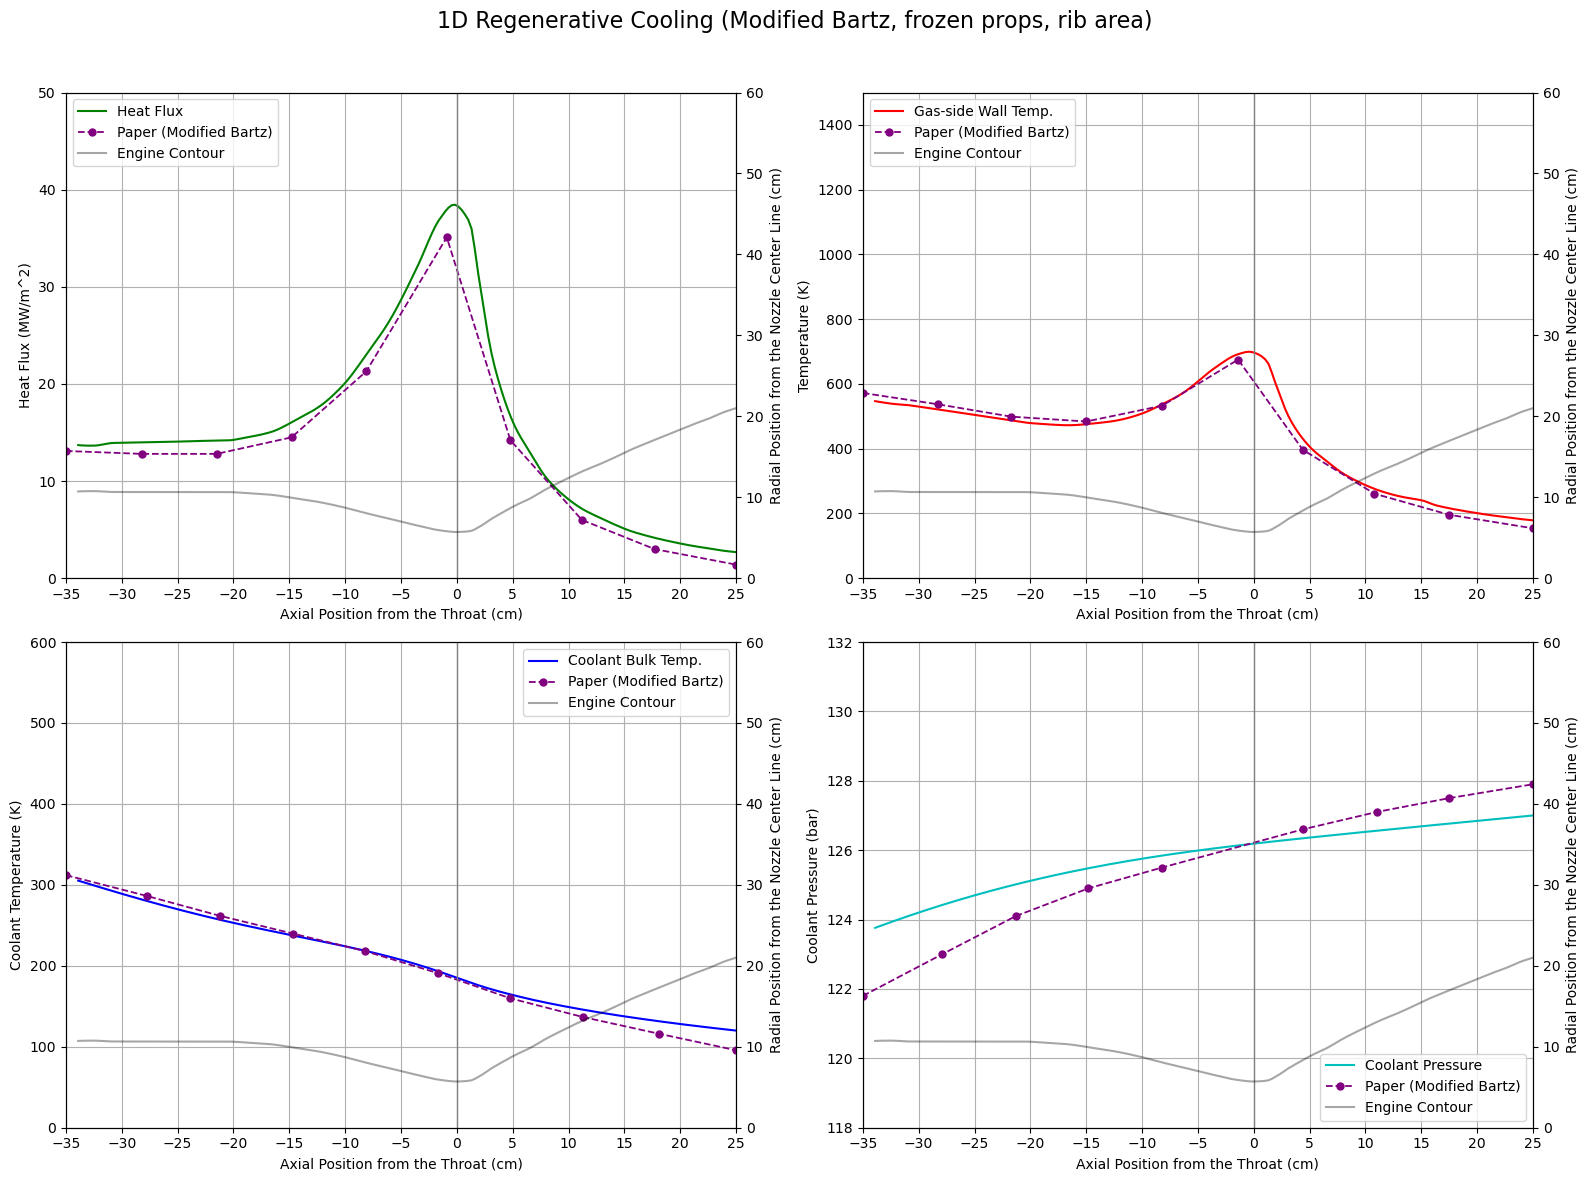

In [28]:
# -*- coding: utf-8 -*-
# 1D 재생냉각 해석 — Modified Bartz Eq.(8) (frozen props, rib area, DB on coolant)
import numpy as np
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import cantera as ct
from scipy.interpolate import PchipInterpolator
from scipy.optimize import brentq

# ==============================================================================
# 0) 노즐 형상 (x: 축방향, y=R: 반경) — throat 기준 x=0
# ==============================================================================
class NozzleContour:
    def __init__(self, contour_data_cm):
        data = np.array(contour_data_cm, dtype=float) / 100.0  # cm -> m
        x, y = data[:, 0], data[:, 1]
        s = np.argsort(x)
        self.x_data, self.y_data = x[s], y[s]
        # throat
        self.throat_idx = np.argmin(self.y_data)
        self.x_throat   = self.x_data[self.throat_idx]
        self.R_t        = self.y_data[self.throat_idx]
        self.D_t        = 2.0 * self.R_t
        self.A_t        = np.pi * self.R_t**2
        # x=0 shift
        self.x_data_shifted = self.x_data - self.x_throat
        # PCHIP + 도함수
        self.spline = PchipInterpolator(self.x_data_shifted, self.y_data, extrapolate=False)
        self.d1     = self.spline.derivative(1)
        self.d2     = self.spline.derivative(2)
        # throat 곡률반경
        self.r_c_throat = self._curvature_radius(0.0)

    def _curvature_radius(self, x):
        dy  = float(self.d1(x))
        d2y = float(self.d2(x))
        denom = (1.0 + dy*dy)**1.5
        kappa = abs(d2y)/denom if denom > 0 else 0.0
        if kappa < 1e-12:
            return 1e9
        return 1.0 / kappa

    def get_radius(self, x):
        R = self.spline(x)
        R = np.where(np.isnan(R), self.R_t, R)
        return np.maximum(R, self.R_t)

    def get_profile(self, x):
        R  = self.get_radius(x)
        A  = np.pi * R**2
        D  = 2.0 * R
        AR = A / self.A_t
        return D, AR

# ==============================================================================
# 1) 리브두께 → 핀효율
# ==============================================================================
class RibThicknessProfile:
    def __init__(self, table_cm_mm):
        arr = np.array(table_cm_mm, dtype=float)
        x_cm, t_mm = arr[:, 0], arr[:, 1]
        s = np.argsort(x_cm)
        x_sorted, t_sorted = x_cm[s], t_mm[s]
        ux, idx = np.unique(x_sorted, return_index=True)
        t_unique = t_sorted[idx]
        self.x_m = ux / 100.0
        self.t_m = t_unique / 1000.0
        self._pchip = PchipInterpolator(self.x_m, self.t_m, extrapolate=True)

    def t_rib(self, x_m):
        return np.maximum(self._pchip(x_m), 1e-4)  # 0.1 mm 하한

def fin_efficiency_eta(h_c, k_wall, t_rib, L_fin, tip_correction=True):
    # 평판핀(양면 대류): m = sqrt(2 h/(k t)), η = tanh(m L_e)/(m L_e)
    t = max(float(t_rib), 1e-6)
    L = max(float(L_fin), 1e-6)
    m  = np.sqrt(2.0 * h_c / (k_wall * t))
    Le = L + 0.5 * t if tip_correction else L
    ml = m * Le
    if ml < 1e-6:
        return 1.0
    return float(np.tanh(ml) / ml)

# ==============================================================================
# 2) Cantera 유틸 (동결 조성, 챔버에서 고정) + c* (choked ideal)
# ==============================================================================
_GAS = ct.Solution('gri30.yaml')
Y_FROZEN = None
GAMMA_CHAMBER = None
R_CHAMBER = None

def set_frozen_composition(of, T0, P0):
    """챔버에서 HP 평형으로 조성 고정 → 전 구간 frozen 물성 사용"""
    global _GAS, Y_FROZEN, GAMMA_CHAMBER, R_CHAMBER
    phi = 4.0 / of  # CH4/O2
    _GAS.set_equivalence_ratio(phi, fuel='CH4', oxidizer='O2')
    _GAS.TP = T0, P0
    _GAS.equilibrate('HP')  # 챔버에서 평형 → 조성 고정
    Y_FROZEN = _GAS.Y.copy()
    cp0 = _GAS.cp_mass; cv0 = _GAS.cv_mass
    GAMMA_CHAMBER = cp0 / cv0
    R_CHAMBER = cp0 - cv0
    return Y_FROZEN, GAMMA_CHAMBER, R_CHAMBER

def gas_props_frozen(T, P):
    """동결 조성(Y_FROZEN)으로 γ, μ, k, cp, Pr 계산"""
    _GAS.TPY = T, P, Y_FROZEN
    cp = _GAS.cp_mass; cv = _GAS.cv_mass
    gamma = cp / cv
    mu = _GAS.viscosity
    k  = _GAS.thermal_conductivity
    Pr = mu * cp / k
    return gamma, mu, cp, k, Pr

def state_with_frozen(T0, P0, AR, flow_type, iters=12):
    """면적비→M 반복(γ는 동결 조성으로 T,P에 의존)"""
    gamma = 1.20
    for _ in range(iters):
        M  = mach_from_area_ratio(AR, gamma, flow_type)
        Ts = T0 / (1.0 + 0.5 * (gamma - 1.0) * M*M)
        Ps = P0 * (Ts / T0)**(gamma / (gamma - 1.0))
        gamma_new, mu, cp, k, Pr = gas_props_frozen(Ts, Ps)
        if abs(gamma_new - gamma) < 1e-4:
            gamma = gamma_new
            break
        gamma = 0.5 * (gamma + gamma_new)
    return M, Ts, Ps, gamma, mu, cp, k, Pr

def cstar_from_chamber(T0, P0):
    """c* = sqrt(R*T0/gamma) * ((γ+1)/2)^{(γ+1)/(2(γ-1))}"""
    gamma = GAMMA_CHAMBER
    R = R_CHAMBER
    return np.sqrt(R*T0/gamma) * ((gamma+1.0)/2.0)**((gamma+1.0)/(2.0*(gamma-1.0)))

# ==============================================================================
# 3) 유동/열전달
# ==============================================================================
def mach_from_area_ratio(area_ratio, gamma=1.4, flow_type='subsonic'):
    f = lambda M: (1.0/M**2) * ((2.0/(gamma+1.0)) * (1.0 + 0.5*(gamma-1.0)*M*M))**((gamma+1.0)/(gamma-1.0)) - area_ratio**2
    if area_ratio < 1.0:
        raise ValueError("A/A*는 1 이상이어야 합니다.")
    if abs(area_ratio - 1.0) < 1e-14:
        return 1.0
    eps = 1e-12
    if flow_type == 'subsonic':
        return brentq(f, eps, 1.0 - eps)
    a, b = 1.0 + eps, 2.0
    while f(b) <= 0.0:
        b *= 2.0
        if b > 1e6:
            raise RuntimeError("상한 탐색 실패")
    return brentq(f, a, b)

# --- Bartz h_g using Eq.(8): centerline(ref) properties, ω=0 ---
def bartz_hg_eq8(mdot_g, A_local, D_t, r_c_throat, mu_ref, cp_ref, k_ref):
    # Eq.(8): h_g = 0.026 * (μ_ref^0.2 * cp_ref / Pr_ref^0.6) * (mdot^0.8 / A^0.9) * ( (π D_t)/(4 r_c) )^0.1 * (1/D_t^0.2)
    #         = 0.026 * μ^{-0.4} * cp^{0.4} * k^{0.6} * (mdot^0.8 / A^0.9) * (π D_t/4 r_c)^0.1 / D_t^0.2
    return (
        0.026
        * (mu_ref ** (-0.4))
        * (cp_ref ** 0.4)
        * (k_ref ** 0.6)
        * (mdot_g ** 0.8) / (A_local ** 0.9)
        * ((np.pi * D_t) / (4.0 * r_c_throat)) ** 0.1
    )

def _friction_factor_colebrook(Re, D_h, eps=1e-6):
    if Re < 2300.0:
        return 64.0 / Re
    g = lambda f: 1.0/np.sqrt(f) + 2.0*np.log10(eps/D_h/3.7 + 2.51/(Re*np.sqrt(f)))
    return brentq(g, 1e-6, 0.2)

def calculate_pressure_drop(m_dot_c, T_c, P_c, A_c, d_h, dx, fluid):
    rho = CP.PropsSI('D', 'T', T_c, 'P', P_c, fluid)
    mu  = CP.PropsSI('V', 'T', T_c, 'P', P_c, fluid)
    v   = m_dot_c / (A_c * rho)
    Re  = rho * v * d_h / mu
    f   = _friction_factor_colebrook(Re, d_h, eps=1e-6)
    return float(f * (dx/d_h) * 0.5 * rho * v * v)

def calculate_h_c(m_dot_c, A_c, d_h, T_c, T_wc, P_c, fluid='Methane', eta_fin=1.0):
    # Dittus–Boelter 유지 (Gnielinski 미적용)
    if not (91 < T_c < 600 and 1e5 < P_c < 200e5):
        return 3.0e4 * eta_fin
    rho = CP.PropsSI('D', 'T', T_c, 'P', P_c, fluid)
    cp  = CP.PropsSI('C', 'T', T_c, 'P', P_c, fluid)
    mu  = CP.PropsSI('V', 'T', T_c, 'P', P_c, fluid)
    k   = CP.PropsSI('L', 'T', T_c, 'P', P_c, fluid)
    Pr  = cp * mu / k
    v   = m_dot_c / (A_c * rho)
    Re  = rho * v * d_h / mu
    if Re < 4000:
        return 1.0e3 * eta_fin
    Nu  = 0.023 * (Re**0.8) * (Pr**0.4)
    h   = Nu * k / d_h
    return h * eta_fin

# ==============================================================================
# 4) 입력 (논문 Table 1,2 기반)
# ==============================================================================
nozzle_contour_data = np.array([
    [-35,10.72], [-33.6,10.76], [-31.8,10.65], [-30.2,10.65], [-28.3,10.65],
    [-26.5,10.65], [-24.5,10.64], [-21.6,10.64], [-20.0,10.53], [-17.8,10.32],
    [-15.3, 9.81], [-13.4, 9.40], [-11.3, 8.78],  [-9.0, 7.96],  [-7.4, 7.45],
     [-4.7, 6.53],  [-2.6, 5.91],  [-1.1, 5.71],   [0.05, 5.81],  [1.0, 6.42],
     [2.0, 7.33],   [2.9, 8.05],   [4.1, 8.96],   [5.5, 9.88],   [6.9, 11.0],
     [8.5,12.12],  [10.2,13.24], [11.8,14.15], [13.1,14.96], [14.5,15.88],
    [16.1,16.80], [18.1,17.91], [20.1,19.03], [21.5,19.74], [22.9,20.56],
    [23.8,20.96], [25,21.57]
])

rib_contour_data = np.array([
    [-35,3.4], [-31.0,3.4], [-27.1,3.4], [-23.0,3.4], [-19.2,3.3], [15.2,3.1],
    [-11.2,2.6], [-7.2,2.1], [-3.2,1.5], [0.5,1.5], [4.5,2.8],
    [8.5,4.0], [12.5,5.1], [16.5,5.1], [20.4,7.0], [25,7.8]
])

heat_flux_data = np.array([
    [-35,13.1], [-28.2,12.8], [-21.5,12.8], [-14.8,14.5], [-8.1,21.3], [-0.9,35.1],
     [4.8,14.2], [11.2,6], [17.7,3.0], [25,1.4]
])

T_wg_data = np.array([
    [-35, 572.0], [-28.3, 537.3], [-21.7, 498.9], [-15.0, 484.0], [-8.2, 532.7], [-1.4, 675.2],
    [4.4, 396.4], [10.8, 261.2], [17.5, 195.9], [25, 154.2]
])

T_c_data = np.array([
    [-35, 312.0], [-27.7, 286.1], [-21.2, 261.7], [-14.7, 239.9], [-8.2, 218.1], [-1.7, 191],
    [4.8, 159.8], [11.3, 136.7], [18.1, 116.1], [25, 95.7]
])

P_c_data = np.array([
    [-35, 121.8], [-27.9, 123.0], [-21.3, 124.1], [-14.8, 124.9], [-8.2, 125.5], [4.4, 126.6],
    [11.0, 127.1], [17.5, 127.5], [25, 127.9]
])

# 챔버 조건 (Table 1)
T_0 = 3603.2       # K
P_0 = 58.6e5       # Pa
O_F = 3.5          # 질량비

# 동결 조성 초기화 + c*
set_frozen_composition(O_F, T_0, P_0)
C_star = cstar_from_chamber(T_0, P_0)

# 냉각 채널/재료 (Table 2)
wall_thickness = 0.7e-3
channel_height = 8.63e-3
channel_width  = 1.08e-3
num_channels   = 150
k_wall         = 300.0      # 구리 라이너 가정
COOLANT_NAME   = 'Methane'
m_dot_coolant  = 6.858          # kg/s
T_c_inlet      = 120.0      # K
P_c_inlet      = 127e5      # Pa
cooling_jacket_end_ar = 15.0

# 파생
nozzle      = NozzleContour(nozzle_contour_data)
rib_profile = RibThicknessProfile(rib_contour_data)

D_t        = nozzle.D_t
A_c_total  = channel_width * channel_height * num_channels
d_h        = 2.0 * (channel_width * channel_height) / (channel_width + channel_height)
r_c_throat = nozzle.r_c_throat

# 가스 질량유량 (Eq.(8)에 필요): \dot{m} = P0 * A* / c*
m_dot_gas = P_0 * nozzle.A_t / C_star

# 해석 세팅
n_segments  = 200
tol         = 1e-5
max_iter    = 1000
alpha_relax = 0.5

# 해석 구간: 수축부 끝 ~ 팽창부 AR=15
x_start = nozzle.x_data_shifted[0]
x_end   = 0.25
for xv in np.linspace(0, 0.5, 500):
    _, ar = nozzle.get_profile(xv)
    if ar >= cooling_jacket_end_ar:
        x_end = xv
        break
x_pos = np.linspace(x_start, x_end, n_segments)
dx    = x_pos[1] - x_pos[0]

# 결과 배열
D_profile   = np.zeros(n_segments)
AR_profile  = np.zeros(n_segments)
T_c_profile = np.zeros(n_segments)
P_c_profile = np.zeros(n_segments)
T_wg_profile= np.zeros(n_segments)
T_wc_profile= np.zeros(n_segments)
q_profile   = np.zeros(n_segments)
h_g_profile = np.zeros(n_segments)

# 경계조건(출구에서 입구로 적분)
T_c_profile[-1] = T_c_inlet
P_c_profile[-1] = P_c_inlet
T_wg_guess_next = 600.0

# ==============================================================================
# 5) 메인 루프 (Eq.(8) 사용)
# ==============================================================================
print("Start 1D regenerative cooling (Bartz Eq.(8), frozen props, rib area) ...")

for i in range(n_segments - 1, -1, -1):
    x = x_pos[i]
    D_local, AR_local = nozzle.get_profile(x)
    D_profile[i], AR_profile[i] = D_local, AR_local
    A_local = np.pi * (0.5 * D_local)**2

    T_c_local, P_c_local = T_c_profile[i], P_c_profile[i]

    flow_type = 'subsonic' if x < 0.0 else 'supersonic'
    M, T_s, P_s, gamma_s, mu_s, cp_s, k_s, Pr_s = state_with_frozen(T_0, P_0, AR_local, flow_type)

    T_wg_iter = float(T_wg_guess_next)
    q = 0.0
    Twc = float(T_c_local)
    Twg_new = float(T_wg_iter)

    for _ in range(max_iter):
        # (a) Eq.(8)으로 h_g 계산 (ref=중심축 Ts, Ps)
        h_g = bartz_hg_eq8(
            mdot_g=m_dot_gas, A_local=A_local, D_t=D_t, r_c_throat=r_c_throat,
            mu_ref=mu_s, cp_ref=cp_s, k_ref=k_s
        )
        # (b) T_aw (복원온도, r = Pr^{1/3})
        r_rec = Pr_s ** (1.0 / 3.0)
        T_aw = T_0 * (1.0 + r_rec * 0.5 * (gamma_s - 1.0) * M*M) / (1.0 + 0.5 * (gamma_s - 1.0) * M*M)

        # (c) 냉각측: Dittus–Boelter
        h_c_raw = calculate_h_c(m_dot_coolant, A_c_total, d_h, T_c_local, T_wg_iter,
                                P_c_local, COOLANT_NAME, eta_fin=1.0)

        # (d) 핀효율 + 면적증대(피치 보정)
        t_rib_loc = float(rib_profile.t_rib(x))
        eta_fin   = fin_efficiency_eta(h_c_raw, k_wall, t_rib_loc, channel_height, tip_correction=True)
        R_gas     = float(nozzle.get_radius(x))
        circ_cool = 2.0 * np.pi * (R_gas + wall_thickness + 0.5*t_rib_loc)
        pitch     = max(circ_cool / num_channels, 1e-6)
        area_ratio = 1.0 + eta_fin * (2.0 * channel_height) / pitch
        h_c_eff = max(h_c_raw * area_ratio, 1.0)

        # (e) 열저항망
        Rg = 1.0 / max(h_g, 1e-12)
        Rw = wall_thickness / k_wall
        Rc = 1.0 / h_c_eff

        q       = max((T_aw - T_c_local) / (Rg + Rw + Rc), 0.0)  # [W/m^2]
        Twc     = T_c_local + q * Rc
        Twg_new = T_aw - q * Rg

        if not np.isfinite(Twg_new):
            break
        if abs(Twg_new - T_wg_iter) < tol:
            break
        T_wg_iter = (1.0 - alpha_relax) * T_wg_iter + alpha_relax * Twg_new

    T_wg_profile[i] = Twg_new
    T_wc_profile[i] = Twc
    q_profile[i]    = q
    h_g_profile[i]  = h_g
    T_wg_guess_next = Twg_new

    # 냉각수 다음 구간 상태
    if i > 0:
        A_ht  = np.pi * D_local * dx
        Q_seg = q * A_ht
        Cp_c  = CP.PropsSI('C', 'T', T_c_local, 'P', P_c_local, COOLANT_NAME)
        T_c_profile[i-1] = T_c_local + Q_seg / (m_dot_coolant * Cp_c)
        dP = calculate_pressure_drop(m_dot_coolant, T_c_local, P_c_local, A_c_total, d_h, dx, COOLANT_NAME)
        P_c_profile[i-1] = P_c_local - dP

# ==============================================================================
# 6) Plot (논문 Fig.6–8과 축/범위 일치, 평활 없음)
# ==============================================================================
x_cm = x_pos * 100.0
R_cm = (D_profile * 0.5) * 100.0

x_hf_ref,  hf_ref  = heat_flux_data[:,0], heat_flux_data[:,1]   # MW/m^2
x_Twg_ref, Twg_ref = T_wg_data[:,0],     T_wg_data[:,1]         # K
x_Tc_ref,  Tc_ref  = T_c_data[:,0],      T_c_data[:,1]          # K
x_Pc_ref,  Pc_ref  = P_c_data[:,0],      P_c_data[:,1]          # bar

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('1D Regenerative Cooling (Modified Bartz, frozen props, rib area)', fontsize=16)

# Heat flux
ax1_t = ax1.twinx()
ax1.plot(x_cm, q_profile/1e6, '-', color='g', label='Heat Flux')
ax1.plot(x_hf_ref, hf_ref, 'o--', color='purple', lw=1.3, ms=5, label='Paper (Modified Bartz)')
ax1_t.plot(x_cm, R_cm, 'k', alpha=0.35, label='Engine Contour')
ax1.set_xlabel('Axial Position from the Throat (cm)')
ax1.set_ylabel('Heat Flux (MW/m^2)')
ax1_t.set_ylabel('Radial Position from the Nozzle Center Line (cm)')
ax1.set_xlim(-35, 25); ax1.set_ylim(0, 50); ax1_t.set_ylim(0, 60)
ax1.set_xticks(np.arange(-35, 26, 5)); ax1.grid(True)
h1,l1 = ax1.get_legend_handles_labels(); h2,l2 = ax1_t.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left')

# Gas-side wall temperature
ax2_t = ax2.twinx()
ax2.plot(x_cm, T_wg_profile, '-', color='r', label='Gas-side Wall Temp.')
ax2.plot(x_Twg_ref, Twg_ref, 'o--', color='purple', lw=1.3, ms=5, label='Paper (Modified Bartz)')
ax2_t.plot(x_cm, R_cm, 'k', alpha=0.35, label='Engine Contour')
ax2.set_xlabel('Axial Position from the Throat (cm)')
ax2.set_ylabel('Temperature (K)')
ax2_t.set_ylabel('Radial Position from the Nozzle Center Line (cm)')
ax2.set_xlim(-35, 25); ax2.set_ylim(0, 1500); ax2_t.set_ylim(0, 60)
ax2.set_xticks(np.arange(-35, 26, 5)); ax2.grid(True)
h1,l1 = ax2.get_legend_handles_labels(); h2,l2 = ax2_t.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc='upper left')

# Coolant temperature
ax3_t = ax3.twinx()
ax3.plot(x_cm, T_c_profile, '-', color='b', label='Coolant Bulk Temp.')
ax3.plot(x_Tc_ref, Tc_ref, 'o--', color='purple', lw=1.3, ms=5, label='Paper (Modified Bartz)')
ax3_t.plot(x_cm, R_cm, 'k', alpha=0.35, label='Engine Contour')
ax3.set_xlabel('Axial Position from the Throat (cm)')
ax3.set_ylabel('Coolant Temperature (K)')
ax3_t.set_ylabel('Radial Position from the Nozzle Center Line (cm)')
ax3.set_xlim(-35, 25); ax3.set_ylim(0, 600); ax3_t.set_ylim(0, 60)
ax3.set_xticks(np.arange(-35, 26, 5)); ax3.grid(True)
h1,l1 = ax3.get_legend_handles_labels(); h2,l2 = ax3_t.get_legend_handles_labels()
ax3.legend(h1+h2, l1+l2, loc='upper right')

# Coolant pressure
ax4_t = ax4.twinx()
ax4.plot(x_cm, P_c_profile/1e5, '-', color='c', label='Coolant Pressure')
ax4.plot(x_Pc_ref, Pc_ref, 'o--', color='purple', lw=1.3, ms=5, label='Paper (Modified Bartz)')
ax4_t.plot(x_cm, R_cm, 'k', alpha=0.35, label='Engine Contour')
ax4.set_xlabel('Axial Position from the Throat (cm)')
ax4.set_ylabel('Coolant Pressure (bar)')
ax4_t.set_ylabel('Radial Position from the Nozzle Center Line (cm)')
ax4.set_xlim(-35, 25); ax4.set_ylim(118, 132); ax4_t.set_ylim(0, 60)
ax4.set_xticks(np.arange(-35, 26, 5)); ax4.grid(True)
h1,l1 = ax4.get_legend_handles_labels(); h2,l2 = ax4_t.get_legend_handles_labels()
ax4.legend(h1+h2, l1+l2, loc='lower right')

for ax in (ax1, ax2, ax3, ax4):
    ax.axvline(0, color='grey', lw=1)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
